## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import math

In [ ]:
# if Colab

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/minRNNs')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/minRNNs


In [ ]:
from minRNNs import minGRU, minLSTM
from models import Model
from baselines import plainGRU, plainLSTM, simpleTransformer, simpleMamba

## Experiment 3.1 : Computational Efficiency Benchmark

In [ ]:
# configuration

DEVICE = "cuda"
DTYPE = torch.float16
BATCH_SIZE = 64
INPUT_DIM = 256
HIDDEN_DIM = 256
LAYERS = 1
SEQ_LENS = [128, 256, 512, 1024, 2048, 4096]
RUNS = 50
torch.manual_seed(0)

In [ ]:
def parallel_scan(a, b):
    """
    Parallel computation of the recurrence:
        h_t = a_t * h_{t-1} + b_t
    using cumulative sums in log-space for numerical stability.
    """
    a_star = F.pad(torch.cumsum(torch.log(a), dim=1), (0, 0, 1, 0))
    log_h = torch.logcumsumexp(torch.log(b) - a_star, dim=1) + a_star
    return torch.exp(log_h)[:, 1:]


# We redefine "manually" plainGRU and plainLSTM so they are compatible with the experience

class PlainGRU(nn.Module):
    """
    Standard GRU implementation with explicit sequential recurrence.
    The hidden state is updated step-by-step over the sequence.
    """
    def __init__(self):
        super().__init__()
        self.z = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # update gate
        self.r = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # reset gate
        self.h = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # candidate state

    def forward(self, x):
        B, T, _ = x.shape
        h = torch.zeros(B, HIDDEN_DIM, device=x.device, dtype=x.dtype)  # initial hidden state
        outputs = []
        for t in range(T):
            xt = x[:, t]
            z = torch.sigmoid(self.z(torch.cat([xt, h], dim=-1)))
            r = torch.sigmoid(self.r(torch.cat([xt, h], dim=-1)))
            h_tilde = torch.tanh(self.h(torch.cat([xt, r * h], dim=-1)))
            h = (1 - z) * h + z * h_tilde
            outputs.append(h)
        return torch.stack(outputs, dim=1)

class PlainLSTM(nn.Module):
    """
    Standard LSTM implementation with sequential time-step updates.
    Maintains both hidden state (h) and cell state (c).
    """
    def __init__(self):
        super().__init__()
        self.f = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # forget gate
        self.i = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # input gate
        self.o = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # output gate
        self.g = nn.Linear(INPUT_DIM + HIDDEN_DIM, HIDDEN_DIM)  # candidate state

    def forward(self, x):
        B, T, _ = x.shape
        h = torch.zeros(B, HIDDEN_DIM, device=x.device, dtype=x.dtype)
        c = torch.zeros_like(h)
        outputs = []
        for t in range(T):
            xt = x[:, t]
            inp = torch.cat([xt, h], dim=-1)
            f = torch.sigmoid(self.f(inp))
            i = torch.sigmoid(self.i(inp))
            o = torch.sigmoid(self.o(inp))
            g = torch.tanh(self.g(inp))
            c = f * c + i * g
            h = o * torch.tanh(c)
            outputs.append(h)
        return torch.stack(outputs, dim=1)


# We redefine "manually" minGRU and minLSTM so they are compatible with parallel_scan
# and follow the same format as PlainGRU and PlainLSTM for a fair comparison

class MinGRU(nn.Module):
    """
    Minimal GRU variant enabling parallel computation across time.
    The recurrence is expressed in the form compatible with parallel_scan.
    """
    def __init__(self):
        super().__init__()
        self.z = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # update gate
        self.h = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # candidate state

    def forward(self, x):
        B, T, _ = x.shape
        z = torch.sigmoid(self.z(x))
        h_tilde = self.h(x)
        h0 = torch.zeros(B, 1, HIDDEN_DIM, device=x.device, dtype=x.dtype)
        b = torch.cat([h0, z * h_tilde], dim=1)
        return parallel_scan(1 - z, b)

class MinLSTM(nn.Module):
    """
    Minimal LSTM variant with normalized gates.
    Reformulates the recurrence so it can be computed with parallel_scan.
    """
    def __init__(self):
        super().__init__()
        self.f = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # forget gate
        self.i = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # input gate
        self.h = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # candidate state

    def forward(self, x):
        B, T, _ = x.shape
        f = torch.sigmoid(self.f(x))
        i = torch.sigmoid(self.i(x))

        # normalized gates
        f_ = f / (f + i + 1e-6)
        i_ = i / (f + i + 1e-6)

        h_tilde = self.h(x)

        h0 = torch.zeros(B, 1, HIDDEN_DIM, device=x.device, dtype=x.dtype)
        b = torch.cat([h0, i_ * h_tilde], dim=1)

        return parallel_scan(f_, b)


In [ ]:
def benchmark(model, seq_len):
    """
    Measures average training time and peak GPU memory usage
    for a given model and sequence length.
    """
    x = torch.randn(BATCH_SIZE, seq_len, INPUT_DIM, device=DEVICE, dtype=DTYPE)
    model = model.to(DEVICE).to(DTYPE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    # run a few steps to stabilize CUDA kernels and memory allocation
    for _ in range(5):
        y = model(x)
        loss = y.mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # reset memory stats before actual measurement
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    start = time.time()
    for _ in range(RUNS):
        y = model(x)
        loss = y.mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    torch.cuda.synchronize()

    # average runtime per iteration (ms)
    elapsed = (time.time() - start) / RUNS * 1000

    # peak GPU memory usage (MB)
    mem = torch.cuda.max_memory_allocated() / 1024**2

    # clear cache
    torch.cuda.empty_cache()

    return elapsed, mem


Sequence length: 128
GRU     | 150.85 ms | 76 MB
LSTM    | 123.20 ms | 69 MB
minGRU  | 3.45 ms | 88 MB
minLSTM | 3.87 ms | 105 MB

Sequence length: 256
GRU     | 266.13 ms | 134 MB
LSTM    | 273.20 ms | 118 MB
minGRU  | 5.65 ms | 157 MB
minLSTM | 7.32 ms | 189 MB

Sequence length: 512
GRU     | 518.29 ms | 246 MB
LSTM    | 550.80 ms | 214 MB
minGRU  | 10.37 ms | 293 MB
minLSTM | 14.17 ms | 357 MB

Sequence length: 1024
GRU     | 1070.03 ms | 470 MB
LSTM    | 1182.10 ms | 406 MB
minGRU  | 19.86 ms | 565 MB
minLSTM | 27.90 ms | 693 MB

Sequence length: 2048
GRU     | 2183.74 ms | 918 MB
LSTM    | 2279.16 ms | 790 MB
minGRU  | 39.18 ms | 1109 MB
minLSTM | 55.42 ms | 1365 MB

Sequence length: 4096
GRU     | 4413.14 ms | 1814 MB
LSTM    | 4689.34 ms | 1558 MB
minGRU  | 78.25 ms | 2197 MB
minLSTM | 110.61 ms | 2709 MB


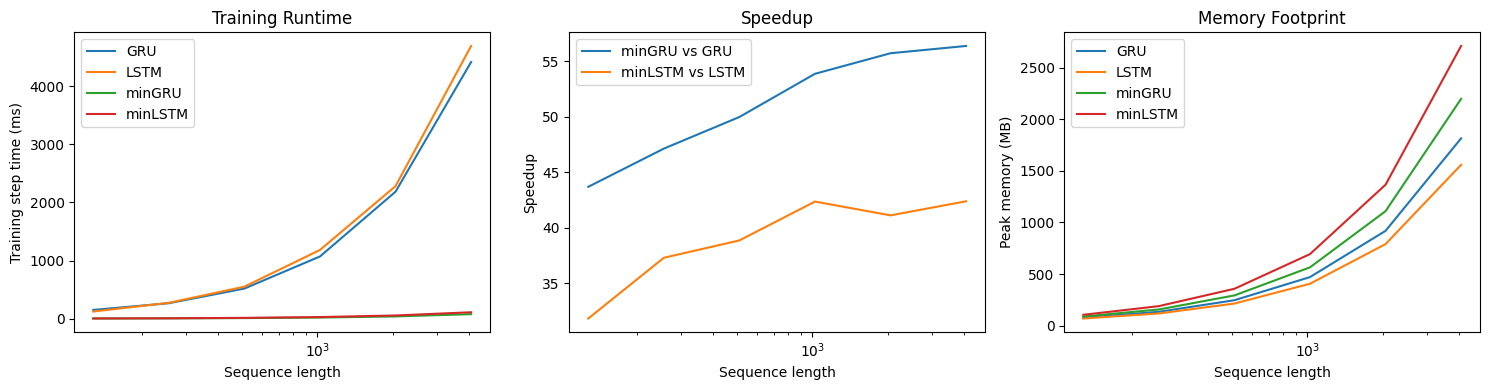

In [ ]:
# run experiments

models = {
    "GRU": PlainGRU(),
    "LSTM": PlainLSTM(),
    "minGRU": MinGRU(),
    "minLSTM": MinLSTM()}

times = {k: [] for k in models}
memory = {k: [] for k in models}

for L in SEQ_LENS:
    print(f"\nSequence length: {L}")
    for name, model in models.items():
        t, m = benchmark(model, L)
        times[name].append(t)
        memory[name].append(m)
        print(f"{name:7s} | {t:.2f} ms | {m:.0f} MB")

plt.figure(figsize=(15, 4))

# Runtime
plt.subplot(1, 3, 1)
for k in models:
    plt.plot(SEQ_LENS, times[k], label=k)
plt.xscale("log")
plt.xlabel("Sequence length")
plt.ylabel("Training step time (ms)")
plt.title("Training Runtime")
plt.legend()

# Speedup (vs GRU/LSTM)
plt.subplot(1, 3, 2)
plt.plot(SEQ_LENS, [times["GRU"][i] / times["minGRU"][i] for i in range(len(SEQ_LENS))], label="minGRU vs GRU")
plt.plot(SEQ_LENS, [times["LSTM"][i] / times["minLSTM"][i] for i in range(len(SEQ_LENS))], label="minLSTM vs LSTM")
plt.xscale("log")
plt.xlabel("Sequence length")
plt.ylabel("Speedup")
plt.title("Speedup")
plt.legend()

# Memory
plt.subplot(1, 3, 3)
for k in models:
    plt.plot(SEQ_LENS, memory[k], label=k)
plt.xscale("log")
plt.xlabel("Sequence length")
plt.ylabel("Peak memory (MB)")
plt.title("Memory Footprint")
plt.legend()

plt.tight_layout()
plt.show()


## Experiment 3.2: Sequence Length Generalization on the Majority Task

### Training

In [ ]:
!python main.py --mode train --task majority --model minGRU --num_layers 3 --kernel_size 4 --expid minGRU_Maj_GenBase

In [ ]:
!python main.py --mode train --task majority --model minLSTM --num_layers 3 --kernel_size 4 --expid minLSTM_Maj_GenBase

In [ ]:
!python main.py --mode train --task majority --model gru --num_layers 3 --kernel_size 4 --expid GRU_Maj_GenBase

In [ ]:
!python main.py --mode train --task majority --model lstm --num_layers 3 --kernel_size 4 --expid LSTM_Maj_GenBase

In [ ]:
!python main.py --mode train --task majority --model transformer --num_layers 3 --kernel_size 4 --expid Transformer_Maj_GenBase

### Test

In [ ]:
!python length_gen_test.py

Benchmarking minGRU...
Benchmarking minLSTM...
Benchmarking GRU...
Benchmarking LSTM...
Benchmarking Transformer...
Figure(1000x600)


## Experiment 3.3: Depth Ablation Test on the Majority Task

In [ ]:
import models as model_file
model_file.sequence_modules.update({
    'minGRU': minGRU,
    'minLSTM': minLSTM,
    'gru': PlainGRU,
    'lstm': PlainLSTM})

### Training

In [ ]:
!python main.py --mode train --task majority --model minGRU --num_layers 1 --kernel_size 4 --expid minGRU_depth1 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: minGRU
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 1
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'minGRU',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 1,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'minGRU_depth1',
 'task':

In [ ]:
!python main.py --mode train --task majority --model minGRU --num_layers 5 --kernel_size 4 --expid minGRU_depth5 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: minGRU
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 5
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'minGRU',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 5,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'minGRU_depth5',
 'task':

In [ ]:
!python main.py --mode train --task majority --model minLSTM --num_layers 1 --kernel_size 4 --expid minLSTM_depth1 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: minLSTM
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 1
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'minLSTM',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 1,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'minLSTM_depth1',
 'tas

In [ ]:
!python main.py --mode train --task majority --model minLSTM --num_layers 5 --kernel_size 4 --expid minLSTM_depth5 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: minLSTM
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 5
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'minLSTM',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 5,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'minLSTM_depth5',
 'tas

In [ ]:
!python main.py --mode train --task majority --model gru --num_layers 1 --kernel_size 4 --expid GRU_depth1 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: gru
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 1
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'gru',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 1,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'GRU_depth1',
 'task': 'majorit

In [ ]:
!python main.py --mode train --task majority --model gru --num_layers 5 --kernel_size 4 --expid GRU_depth5 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: gru
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 5
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'gru',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 5,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'GRU_depth5',
 'task': 'majorit

In [ ]:
!python main.py --mode train --task majority --model lstm --num_layers 1 --kernel_size 4 --expid LSTM_depth1 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: lstm
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 1
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'lstm',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 1,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'LSTM_depth1',
 'task': 'majo

In [ ]:
!python main.py --mode train --task majority --model lstm --num_layers 5 --kernel_size 4 --expid LSTM_depth5 \
--num_steps 1200 --d_model 256 --eval_freq 300 --print_freq 200 &

No specialized Arguments for majority


Overriding argument num_steps: 1200
Overriding argument print_freq: 200
Overriding argument eval_freq: 300
Overriding argument val_seed: 0
Overriding argument test_seed: 1
Overriding argument model: lstm
Overriding argument d_model: 256
Overriding argument kernel_size: 4
Overriding argument num_layers: 5
{'ff_mult': 2,
 'wd': 0.05,
 'forget_bias_init_scale': 3,
 'train_seed': 42,
 'model': 'lstm',
 'check_exists': False,
 'enable_ff': False,
 'use_coeff_norm': False,
 'use_init_hidden_state': True,
 'norm_type': 'RMSNorm',
 'train_batch_size': 128,
 'accum_iter': 1,
 'num_steps': 1200,
 'lr': 0.0003,
 'clip': None,
 'print_freq': 200,
 'save_freq': 1000,
 'eval_freq': 300,
 'val_seed': 0,
 'test_seed': 1,
 'eval_num_batches': 200,
 'eval_batch_size': 256,
 'd_model': 256,
 'expand_dim': 1,
 'dropout': 0.0,
 'num_layers': 5,
 'kernel_size': 4,
 'vocab_size': 64,
 'd_in': None,
 'd_out': 63,
 'mode': 'train',
 'expid': 'LSTM_depth5',
 'task': 'majo

## Test

In [ ]:
!python depth_abl_test.py


Evaluating minGRU
minGRU_depth1: 0.3219
minGRU_depth5: 0.3259

Evaluating minLSTM
minLSTM_depth1: 0.4944
minLSTM_depth5: 0.3300

Evaluating GRU
GRU_depth1: 0.4006
GRU_depth5: 0.3831

Evaluating LSTM
LSTM_depth1: 0.4088
LSTM_depth5: 0.3509
Figure(1000x600)


## Experiment 3.4: Character-Level Language Modeling on TinyShakespeare

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-02-25 12:07:58--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.3’

input.txt.3         100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2026-02-25 12:07:59 (42.8 MB/s) - ‘input.txt.3’ saved [1115394/1115394]



In [ ]:
# Data loading
def load_data():
    with open('input.txt', 'r') as f:
        text = f.read()
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = { ch:i for i,ch in enumerate(chars) }
    data = torch.tensor([stoi[c] for c in text], dtype=torch.long)
    n = int(0.9 * len(data))
    return data[:n], data[n:], vocab_size


In [ ]:
train_ds, val_ds, v_size = load_data()

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Vocabulary:", v_size)

Train size: 1003854
Validation size: 111540
Vocabulary: 65


In [ ]:
def train_config(name, module_type, train_data, val_data, vocab_size):
    """Train a sequence model configuration and track train/validation loss."""
    device = 'cuda'

    # Register normalization layers
    import models as model_file
    model_file.norms['rmsnorm'] = nn.RMSNorm

    # Model-specific configuration
    rnn_configs = {
    'minGRU': {
        'dim': 384,
        'expansion_factor': 2,
        'use_init_hidden_state': True,
        'forget_bias_init_scale': None,
        'use_coeff_norm': False},
    'minLSTM': {
        'dim': 384,
        'expansion_factor': 2,
        'use_init_hidden_state': True,
        'forget_bias_init_scale': 3.0,
        'use_coeff_norm': True},
    'mamba': {
        'dim': 384,
        'expansion_factor': 2,
        'use_init_hidden_state': False,
        'forget_bias_init_scale': None,
        'use_coeff_norm': False},
    'transformer': {
        'dim': 384,
        'expansion_factor': 2,
        'use_init_hidden_state': False,
        'forget_bias_init_scale': None,
        'use_coeff_norm': False}}

    # Build model
    model = Model(
        module=module_type,
        num_tokens=vocab_size,
        d_in=None,
        d_out=vocab_size,
        dim=384,
        depth=3,
        dropout=0.2,
        ff_mult=4,
        conv_kernel_size=4,
        enable_conv=True,
        enable_ff=True,
        norm_type='rmsnorm',
        rnn_config=rnn_configs[module_type]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    train_losses, val_losses = [], []
    steps = []

    print(f"\n--- Starting {name} (5000 Steps) ---")

    for step in range(5001):

        # Training step
        model.train()

        ix = torch.randint(len(train_data) - 128, (64,))
        x = torch.stack([train_data[i:i+128] for i in ix]).to(device)
        y = torch.stack([train_data[i+1:i+129] for i in ix]).to(device)

        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)

        optimizer.step()

        # Validation step
        if step % 100 == 0:
            model.eval()
            with torch.no_grad():

                ix_v = torch.randint(len(val_data) - 128, (64,))
                xv = torch.stack([val_data[i:i+128] for i in ix_v]).to(device)
                yv = torch.stack([val_data[i+1:i+129] for i in ix_v]).to(device)

                v_logits = model(xv)
                v_loss = F.cross_entropy(
                    v_logits.view(-1, vocab_size),
                    yv.view(-1))

                train_losses.append(loss.item())
                val_losses.append(v_loss.item())
                steps.append(step)

                print(f"Step {step} | Train: {loss.item():.4f} | Val: {v_loss.item():.4f}")

    return steps, train_losses, val_losses


--- Starting minGRU (5000 Steps) ---
Step 0 | Train: 4.3600 | Val: 4.4318
Step 100 | Train: 1.6438 | Val: 1.8193
Step 200 | Train: 1.4464 | Val: 1.6667
Step 300 | Train: 1.3994 | Val: 1.6171
Step 400 | Train: 1.2924 | Val: 1.6122
Step 500 | Train: 1.2698 | Val: 1.5582
Step 600 | Train: 1.2064 | Val: 1.5465
Step 700 | Train: 1.2217 | Val: 1.6130
Step 800 | Train: 1.1619 | Val: 1.5977
Step 900 | Train: 1.1484 | Val: 1.5400
Step 1000 | Train: 1.0325 | Val: 1.6720
Step 1100 | Train: 1.0524 | Val: 1.5966
Step 1200 | Train: 1.0218 | Val: 1.6557
Step 1300 | Train: 0.9806 | Val: 1.7466
Step 1400 | Train: 0.9099 | Val: 1.8027
Step 1500 | Train: 0.9065 | Val: 1.6608
Step 1600 | Train: 0.8835 | Val: 1.7389
Step 1700 | Train: 0.8794 | Val: 1.8200
Step 1800 | Train: 0.7784 | Val: 1.9370
Step 1900 | Train: 0.7497 | Val: 2.0309
Step 2000 | Train: 0.7451 | Val: 1.9389
Step 2100 | Train: 0.6918 | Val: 1.9700
Step 2200 | Train: 0.6379 | Val: 2.2018
Step 2300 | Train: 0.6330 | Val: 2.1275
Step 2400 | Tr

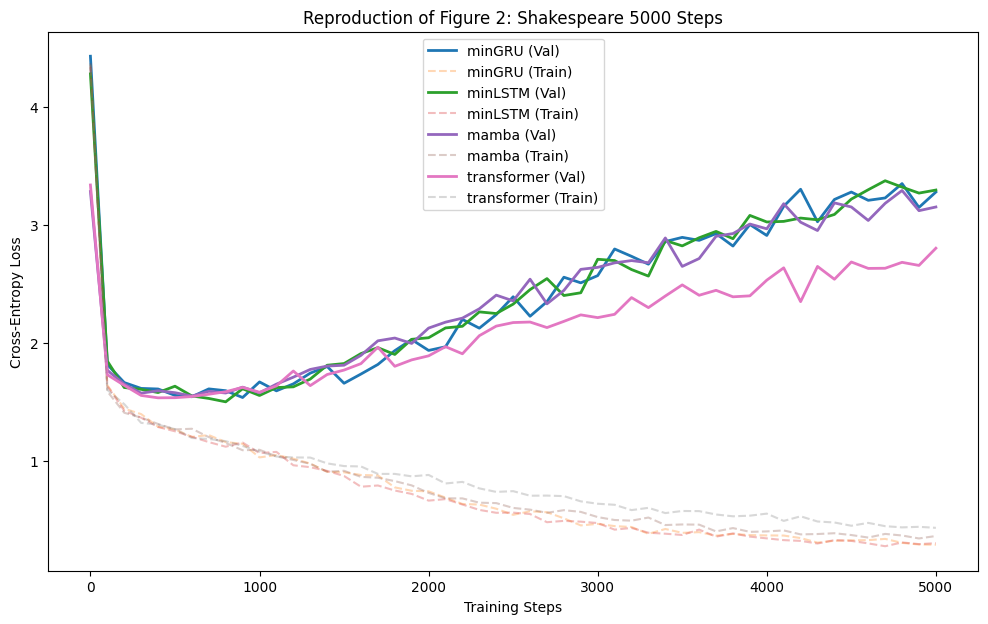

In [ ]:
# run experiments

all_results = {}
for m in ['minGRU', 'minLSTM', 'mamba', 'transformer']:
    all_results[m] = train_config(m, m, train_ds, val_ds, v_size)

plt.figure(figsize=(12, 7))
for name, (steps, t_loss, v_loss) in all_results.items():
    plt.plot(steps, v_loss, label=f"{name} (Val)", linewidth=2)
    plt.plot(steps, t_loss, '--', alpha=0.3, label=f"{name} (Train)")

plt.title("Reproduction of Figure 2: Shakespeare 5000 Steps")
plt.xlabel("Training Steps"); plt.ylabel("Cross-Entropy Loss"); plt.legend(); plt.show()

## Experiment 3.5: Character-Level Language Modeling on TreeBank

In [ ]:
!wget https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt
!wget https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt

--2026-02-25 12:53:50--  https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5101618 (4.9M) [text/plain]
Saving to: ‘ptb.train.txt.2’

ptb.train.txt.2     100%[===================>]   4.87M  --.-KB/s    in 0.1s    

2026-02-25 12:53:51 (49.4 MB/s) - ‘ptb.train.txt.2’ saved [5101618/5101618]

--2026-02-25 12:53:51--  https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399782 (390K) [text/pl

In [ ]:
# Data loading
def load_ptb():
    with open("ptb.train.txt") as f:
        train_text = f.read()
    with open("ptb.valid.txt") as f:
        val_text = f.read()
    chars = sorted(list(set(train_text + val_text)))
    vocab_size = len(chars)
    stoi = {ch:i for i,ch in enumerate(chars)}
    train_data = torch.tensor([stoi[c] for c in train_text], dtype=torch.long)
    val_data = torch.tensor([stoi[c] for c in val_text], dtype=torch.long)
    return train_data, val_data, vocab_size


In [ ]:
train_ptb, val_ptb, ptb_vocab = load_ptb()

print("Train size:", len(train_ptb))
print("Validation size:", len(val_ptb))
print("Vocabulary:", ptb_vocab)

Train size: 5101618
Validation size: 399782
Vocabulary: 50


In [ ]:
def ptb_experiment(module_type):
    """Run a PTB training experiment for a given model"""

    device = "cuda"

    # Register normalization layers
    import models as model_file
    model_file.norms['rmsnorm'] = nn.RMSNorm

    # Model-specific configuration
    rnn_configs = {
        'minLSTM': {
            'dim': 384,
            'expansion_factor': 2,
            'use_init_hidden_state': True,
            'forget_bias_init_scale': 3.0,
            'use_coeff_norm': True},
        'transformer': {
            'dim': 384,
            'expansion_factor': 2,
            'use_init_hidden_state': False,
            'forget_bias_init_scale': None,
            'use_coeff_norm': False}}

    model = Model(
        module=module_type,
        num_tokens=ptb_vocab,
        d_in=None,
        d_out=ptb_vocab,
        dim=384,
        depth=3,
        dropout=0.2,
        conv_kernel_size=4,
        enable_conv=True,
        enable_ff=True,
        norm_type='rmsnorm',
        ff_mult=4,
        rnn_config=rnn_configs[module_type]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Training loop
    for step in range(2000):

        # Sample random PTB train batches
        ix = torch.randint(len(train_ptb) - 128, (64,))
        x = torch.stack([train_ptb[i:i+128] for i in ix]).to(device)
        y = torch.stack([train_ptb[i+1:i+129] for i in ix]).to(device)

        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, ptb_vocab), y.view(-1))

        preds = logits.argmax(dim=-1)
        train_acc = (preds == y).float().mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:

            train_losses.append(loss.item())
            train_accs.append(train_acc.item())

            # Validation batch
            ix = torch.randint(len(val_ptb) - 128, (64,))
            x_val = torch.stack([val_ptb[i:i+128] for i in ix]).to(device)
            y_val = torch.stack([val_ptb[i+1:i+129] for i in ix]).to(device)

            with torch.no_grad():
                logits_val = model(x_val)
                val_loss = F.cross_entropy(logits_val.view(-1, ptb_vocab), y_val.view(-1))
                val_preds = logits_val.argmax(dim=-1)
                val_acc = (val_preds == y_val).float().mean()

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())

            print(f"[{module_type}] step {step:3d} | "
            f"train_loss: {loss.item():.4f} | train_acc: {train_acc.item():.3f} | "
            f"val_loss: {val_loss.item():.4f} | val_acc: {val_acc.item():.3f}")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
ptb_results = {}

for m in ["minLSTM","transformer"]:
    train_l, val_l, train_a, val_a = ptb_experiment(m)
    ptb_results[m] = {
        "train_losses": train_l,
        "val_losses": val_l,
        "train_accs": train_a,
        "val_accs": val_a}

[minLSTM] step   0 | train_loss: 4.2094 | train_acc: 0.016 | val_loss: 4.5920 | val_acc: 0.185
[minLSTM] step  50 | train_loss: 2.0387 | train_acc: 0.393 | val_loss: 2.0334 | val_acc: 0.401
[minLSTM] step 100 | train_loss: 1.8127 | train_acc: 0.455 | val_loss: 1.7922 | val_acc: 0.463
[minLSTM] step 150 | train_loss: 1.5404 | train_acc: 0.534 | val_loss: 1.5531 | val_acc: 0.533
[minLSTM] step 200 | train_loss: 1.3868 | train_acc: 0.578 | val_loss: 1.3738 | val_acc: 0.584
[minLSTM] step 250 | train_loss: 1.3262 | train_acc: 0.592 | val_loss: 1.3495 | val_acc: 0.586
[minLSTM] step 300 | train_loss: 1.3188 | train_acc: 0.593 | val_loss: 1.3121 | val_acc: 0.599
[minLSTM] step 350 | train_loss: 1.2947 | train_acc: 0.592 | val_loss: 1.2882 | val_acc: 0.599
[minLSTM] step 400 | train_loss: 1.2284 | train_acc: 0.622 | val_loss: 1.2183 | val_acc: 0.623
[minLSTM] step 450 | train_loss: 1.1896 | train_acc: 0.628 | val_loss: 1.2300 | val_acc: 0.621
[minLSTM] step 500 | train_loss: 1.1621 | train_ac

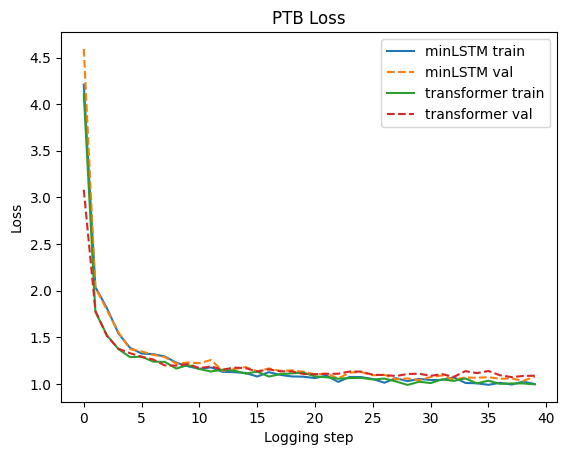

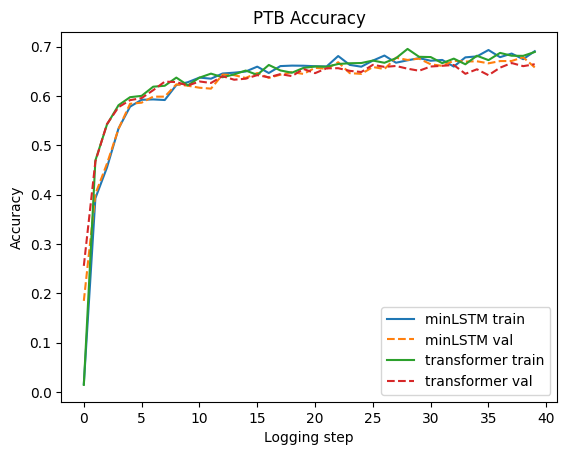

In [ ]:
# losses
plt.figure()

for m in ["minLSTM", "transformer"]:
    plt.plot(ptb_results[m]["train_losses"], label=f"{m} train")
    plt.plot(ptb_results[m]["val_losses"], linestyle="--", label=f"{m} val")

plt.xlabel("Logging step")
plt.ylabel("Loss")
plt.legend()
plt.title("PTB Loss")
plt.show()

# accuracies
plt.figure()

for m in ["minLSTM", "transformer"]:
    plt.plot(ptb_results[m]["train_accs"], label=f"{m} train")
    plt.plot(ptb_results[m]["val_accs"], linestyle="--", label=f"{m} val")

plt.xlabel("Logging step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("PTB Accuracy")
plt.show()